In [1]:
# For this notebook, we've picked an instance of maxcut. Other problems are more interesting,
# but this is the one always used in the literature.

# The goal here is to setup a Maxcut QAOA instance using qiskit, and execute it on the qiskit simulator
# using the ColdQuanta API. To validate our results, we will look for the canonical ``qaoa landscape" and 
# see that it loses contrast when the noise is increased.

In [2]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
# Set up a 2x2 grid topology.
rows = 1
cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


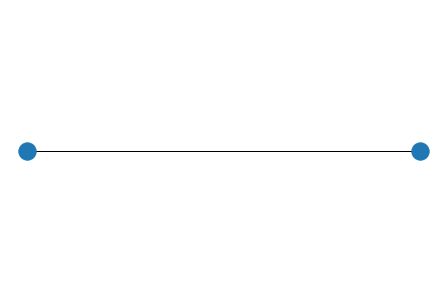

In [3]:
from networkx import Graph, draw_planar
g = Graph(coupling_map)
draw_planar(g)

In [4]:
# We will currently only accept QAOA instances on graphs isomorphic to our own -
# i.e. we are not implementing a compiler. Provide them as a dictionary.

# Uniform weights.
weights = set()
for k in coupling_map:
    weights.add((min(k), max(k)))
weights = {k: 1 for k in weights}

In [5]:
from classical_optimization.qaoa_circuits import maxcut_qaoa_circuit

In [6]:
maxcut_qaoa_circuit(gammas=[0],betas=[0], p=1, weights=weights, rows=rows, cols=cols).draw()

┌───┐ ░                                     ░ ┌───────┐ ░ ┌─┐   
   q_0: ┤ H ├─░───────■─────────────────────■───────░─┤ RX(0) ├─░─┤M├───
        ├───┤ ░ ┌───┐ │ ┌───┐┌───────┐┌───┐ │ ┌───┐ ░ ├───────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ H ├─■─┤ H ├┤ RZ(0) ├┤ H ├─■─┤ H ├─░─┤ RX(0) ├─░──╫─┤M├
        └───┘ ░ └───┘   └───┘└───────┘└───┘   └───┘ ░ └───────┘ ░  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════════╩══╬═
                                                                      ║ 
meas_1: ══════════════════════════════════════════════════════════════╩═

In [45]:
def estimate_cost(counts, weights):
    cost = 0
    for assignment, count in counts.items():
        for edge, weight in weights.items():
            if assignment[edge[0]] != assignment[edge[1]]:
                # We've cut this edge.
                cost += weight*count
    return cost/sum(counts.values()) 

In [46]:
import numpy as np
discretization = 20
max_gamma = max_beta = np.pi
gammas = np.linspace(0, max_gamma, discretization)
betas = np.linspace(0, max_beta, discretization)

In [47]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [48]:
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

0.99609375
0.0029296875


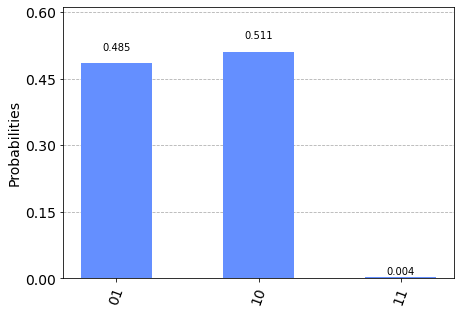

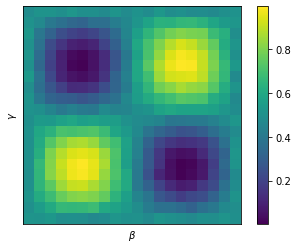

In [49]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(landscape)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,
    labelleft=False,        # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
print(np.max(landscape))
print(np.min(landscape))
plt.colorbar()
plot_histogram(all_counts[np.argmax(landscape)])

# Now introduce noise!

In [50]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

In [51]:
noise_model = create_noise_model()

In [52]:
noise_model

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u3']
  Instructions with noise: ['r', 'cz', 'id', 'rz']
  All-qubits errors: ['r', 'rz', 'id', 'cz']

In [53]:
noise_model = create_noise_model(cz_fidelity=0.7)

experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  
all_counts = job.result().get_counts()

In [54]:
noisy_landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

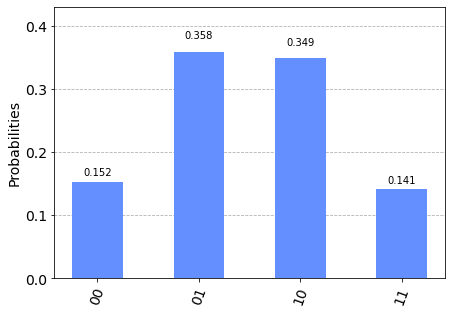

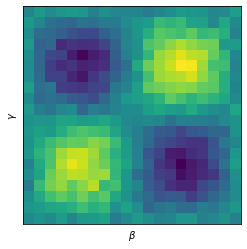

In [55]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(noisy_landscape)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,
    labelleft=False,        # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")

plot_histogram(all_counts[np.argmax(noisy_landscape)])

# Include Classical Optimizer

In [62]:
from scipy.optimize import minimize

def execute_qaoa_circuit_and_estimate_cost(gamma, beta, num_shots, simulator, coupling_map, weights, *, noise_model=None):
    circuit = maxcut_qaoa_circuit(gammas=[gamma], betas=[beta], p=1, rows=rows, cols=cols, weights=weights)
    job = execute(circuit,
                  simulator,
                  noise_model=noise_model,
                  coupling_map=coupling_map,
                  optimization_level=0,
                  shots=num_shots)  
    all_counts = job.result().get_counts()
    return estimate_cost(all_counts, weights)

In [63]:
simulator = Aer.get_backend('qasm_simulator')
shots_per_point = 1000

# HACK, history will need to be reinitialized everytime the optimizer is called.
def store_log(func):
    def logged_func(x):
        history.append(x)
        return func(x)
    return logged_func

@store_log
def gamma_beta_objective(gamma_beta):
    return -execute_qaoa_circuit_and_estimate_cost(gamma=gamma_beta[0], beta=gamma_beta[1], num_shots=shots_per_point,
                                                   simulator=simulator,
                                                   coupling_map=neutral_atom_config.coupling_map,
                                                   weights=weights)

In [64]:
def gamma_beta_to_index(gamma, beta, discretization):
    return (gamma * discretization/max_gamma)%(discretization-1), (beta * discretization/max_beta)%(discretization-1)
def plot_history_over_landscape(history, landscape, discretization):
    plt.imshow(landscape)
    plt.ylabel(r"$\gamma$")
    plt.xlabel(r"$\beta$")
    plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,
    labelleft=False,        # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    
    plt.colorbar()
    for i, point in enumerate(history[1:-1]):
        plt.scatter(*gamma_beta_to_index(*point, discretization), c='r')
    plt.scatter(*gamma_beta_to_index(*history[0], discretization), marker='.', s=200, c='w')
    plt.scatter(*gamma_beta_to_index(*history[-1], discretization), marker='*', s=200, c='w')

In [65]:
def try_optimizer(optimizer):
    global history
    history = []
    initial_gamma_beta = [np.random.rand() * max_param for max_param in (max_gamma, max_beta)]
    result = minimize(gamma_beta_objective, x0=initial_gamma_beta, method=optimizer)
    print(fr'$\gamma$,$\beta$={result.x}')
    print(f'Max cut is {-result.fun}')
    plot_history_over_landscape(history, landscape, discretization)
    plt.title(optimizer)
    plt.show()

In [66]:
methods = ['Nelder-Mead',
           'Powell',
           'CG',
           'BFGS',
           # 'Newton-CG',
           'L-BFGS-B',
           'TNC', 
           'COBYLA',
           'SLSQP',
           'trust-constr',
           #'dogleg',
           #'trust-ncg',
           #'trust-krylov',
           #'trust-exact'
          ]

$\gamma$,$\beta$=[0.94263021 0.10762172]
Max cut is 0.445


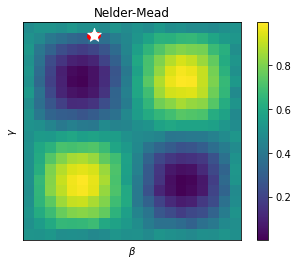

$\gamma$,$\beta$=[2.35342738 0.77430336]
Max cut is 1.0


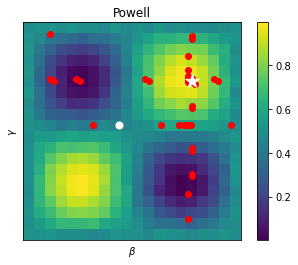

$\gamma$,$\beta$=[2.16063856 1.97741895]
Max cut is 0.182


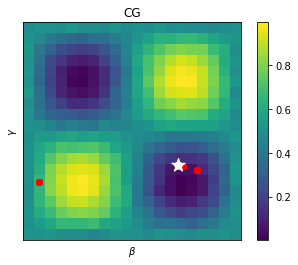

$\gamma$,$\beta$=[0.7314762  0.05931209]
Max cut is 0.464


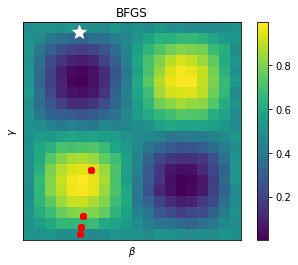

$\gamma$,$\beta$=[2.80683338 1.48919625]
Max cut is 0.562


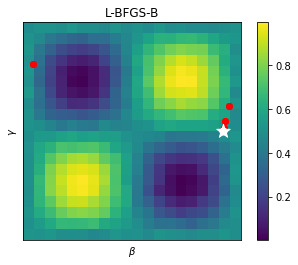

$\gamma$,$\beta$=[1.50059033 0.70305308]
Max cut is 0.431


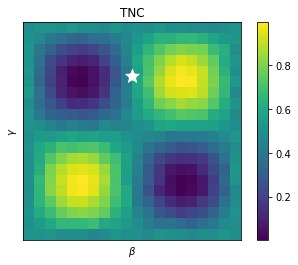

$\gamma$,$\beta$=[2.36689837 0.79324168]
Max cut is 1.0


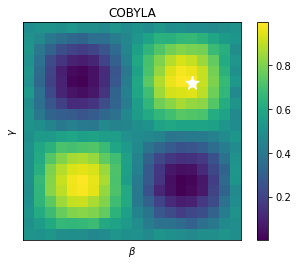

$\gamma$,$\beta$=[ 4748.96957138 -1094.03908059]
Max cut is 0.116


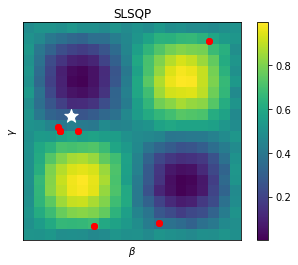

$\gamma$,$\beta$=[2.38982184 0.58488831]
Max cut is 0.97


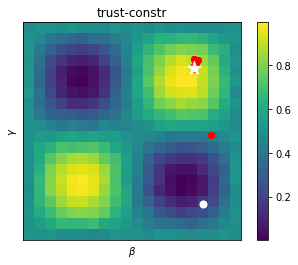

In [67]:
# It looks like my plotting is incorrect.
for method in methods:
    try_optimizer(method)

In [3]:
circuit.draw()

┌───┐┌─────┐
q_0: ┤ H ├┤ foo ├
     └───┘└─────┘

In [7]:
backend = Aer.get_backend('qasm_simulator')
backend_options={'method': 'density_matrix'}
job = execute(circuit, backend=backend, backend_options=backend_options, shots=1)

In [23]:
job.result().results[0].data.snapshots.density_matrix['foo'][0]['value']

[[[0.5000000000000001, 0.0], [0.5, 0.0]],
 [[0.5, 0.0], [0.4999999999999999, 0.0]]]